In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from mnist import MNIST
from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torchvision.datasets as datasets

In [128]:
from sklearn.metrics import auc

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [5]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [6]:
# !pip install python-mnist

In [7]:
len(mnist_trainset)

60000

In [8]:
len(mnist_testset)

10000

In [9]:
len(mnist_trainset.data), len(mnist_trainset.targets)

(60000, 60000)

Train: X=torch.Size([60000, 28, 28]), y=torch.Size([60000])
Test: X=torch.Size([10000, 28, 28]), y=torch.Size([10000])


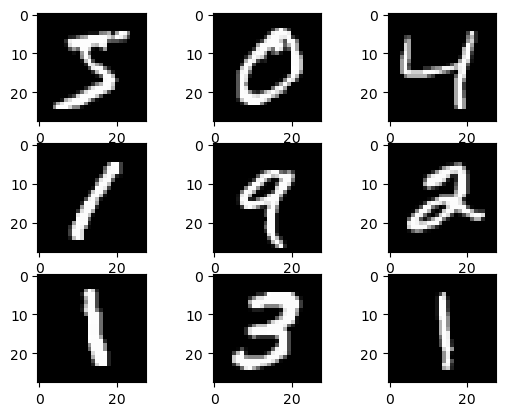

In [10]:
(trainX, trainy) = mnist_trainset.data, mnist_trainset.targets

(testX, testy) = mnist_testset.data, mnist_testset.targets

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

In [11]:
for i in range(10):
  count_train = np.where(trainy == i)[0]
  count_test = np.where(testy == i)[0]

  print("Label %d - train: %.4f - test: %.4f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Label 0 - train: 0.0987 - test: 0.0980
Label 1 - train: 0.1124 - test: 0.1135
Label 2 - train: 0.0993 - test: 0.1032
Label 3 - train: 0.1022 - test: 0.1010
Label 4 - train: 0.0974 - test: 0.0982
Label 5 - train: 0.0903 - test: 0.0892
Label 6 - train: 0.0986 - test: 0.0958
Label 7 - train: 0.1044 - test: 0.1028
Label 8 - train: 0.0975 - test: 0.0974
Label 9 - train: 0.0992 - test: 0.1009


In [12]:
# prepare data for training
trainX.shape, trainy.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [13]:
trainX.shape

torch.Size([60000, 28, 28])

In [14]:
torch.mean(trainX.to(torch.float))

tensor(33.3184)

In [15]:
torch.std(trainX.to(torch.float))

tensor(78.5675)

In [16]:
train_x_norm = (trainX - torch.mean(trainX.to(torch.float))) / torch.std(trainX.to(torch.float))

In [17]:
trainy

tensor([5, 0, 4,  ..., 5, 6, 8])

In [18]:
train_ds = TensorDataset(train_x_norm, trainy)
torch.manual_seed(1234)
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [19]:
class DNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(DNN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    x = self.fc1(x)
    x = nn.Sigmoid()(x)
    x = self.fc2(x)
    # x = nn.Softmax(dim=1)(x)
    return x

In [20]:
input_size = 28*28
hidden_size = 100
num_classes = 10
learning_rate = 0.001
num_epochs = 20

model = DNN(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()


In [21]:
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

In [22]:
i = 1
for epoch in range(num_epochs):
    print(i)
    for x_batch, y_batch in train_dl.dataset:
        pred = model(torch.flatten(x_batch))
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.item()
        is_correct = (torch.argmax(pred) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    accuracy_hist[epoch] /= len(train_dl.dataset)
    loss_hist[epoch] /= len(train_dl.dataset)
    i += 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


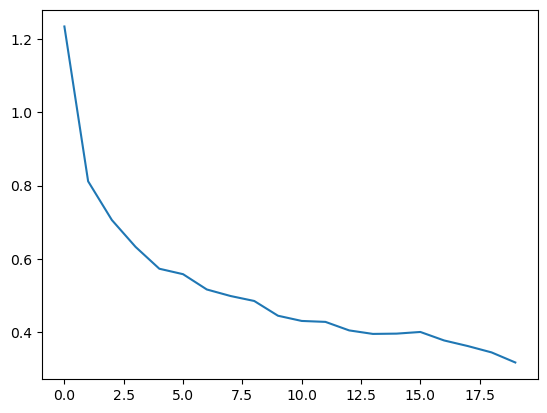

In [23]:
plt.plot(loss_hist)

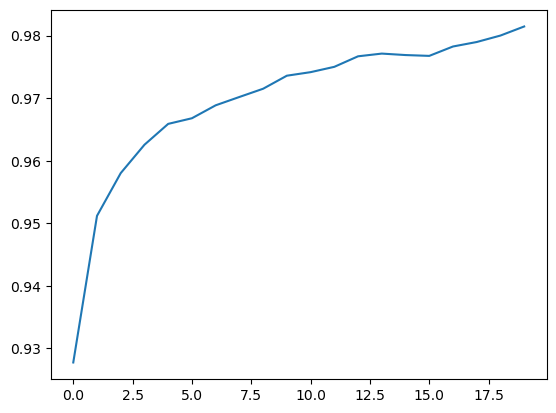

In [24]:
plt.plot(accuracy_hist)

In [60]:
accuracy_hist[-1].item()

0.9814500212669373

In [62]:
#Report:
#precision
#recall
#ROC curve
#confusion matrix

In [66]:
testX = testX.to(torch.float)

In [68]:
X_test_norm = (testX - torch.mean(testX)) / torch.std(testX)

In [86]:
X_test_norm.shape

torch.Size([28, 28, 10000])

In [88]:
X_test_norm = torch.transpose(X_test_norm, 0, 2)

In [94]:
X_test_norm.shape

torch.Size([10000, 28, 28])

In [96]:
pred_test = model(torch.flatten(X_test_norm, start_dim=1, end_dim=2))

In [120]:
pred_class_test = torch.argmax(pred_test, dim=1)

In [124]:
correct = (pred_class_test == testy).float()

In [130]:
precision_by_class = [0] * num_classes
recall_by_class = [0] * num_classes
auroc = [0] * num_classes

In [ ]:
#need to confirm
for i in range(num_classes):
    
    p_index = (pred_class_test == i)
    
    precision_by_class[i] =  correct[p_index].sum() / sum(p_index) 
    
    r_index = (testy == i)
    recall_by_class[i] = correct[r_index].sum() / sum(r_index)

    
    
    auc[i] = auc(correct[r_index],    




In [106]:
precision = correct.sum()/pred_test.shape[0]
precision.item()

tensor(0.9680)

In [110]:
recall = correct.sum()/
recall.item()

0.2178511917591095

In [112]:
pred_test.shape[0]

10000

In [116]:
testy

tensor([7, 2, 1,  ..., 4, 5, 6])

In [140]:
(testy == 5)

tensor(892)

In [146]:
len(correct[testy == 5])

892